Przeprowadzić analizę mocy wybranych testów statystycznych w różnych warunkach. Badaniu poddane zostaną testy Kołmogorowa, Lillieforsa, Andersona-Darlinga oraz test Kołmogorowa-Smirnowa, zarówno w klasycznej wersji, jak i z wykorzystaniem transformacji PIT (probability integral transform).

# Zdanie 1
Wpływ rozkładu danych na moc testów 
Zbadanie mocy testów w przypadku, gdy dane pochodzą z różnych rozkładów:

- Rozkład t-Studenta (z uwzględnieniem liczby stopni swobody),
- Rozkład χ2 (z uwzględnieniem liczby stopni swobody),
- Rozkłady normalne o różnych odchyleniach standardowych przy stałej wartości oczekiwanej,
- Rozkłady NIG  i gamma o różnych parametrach.

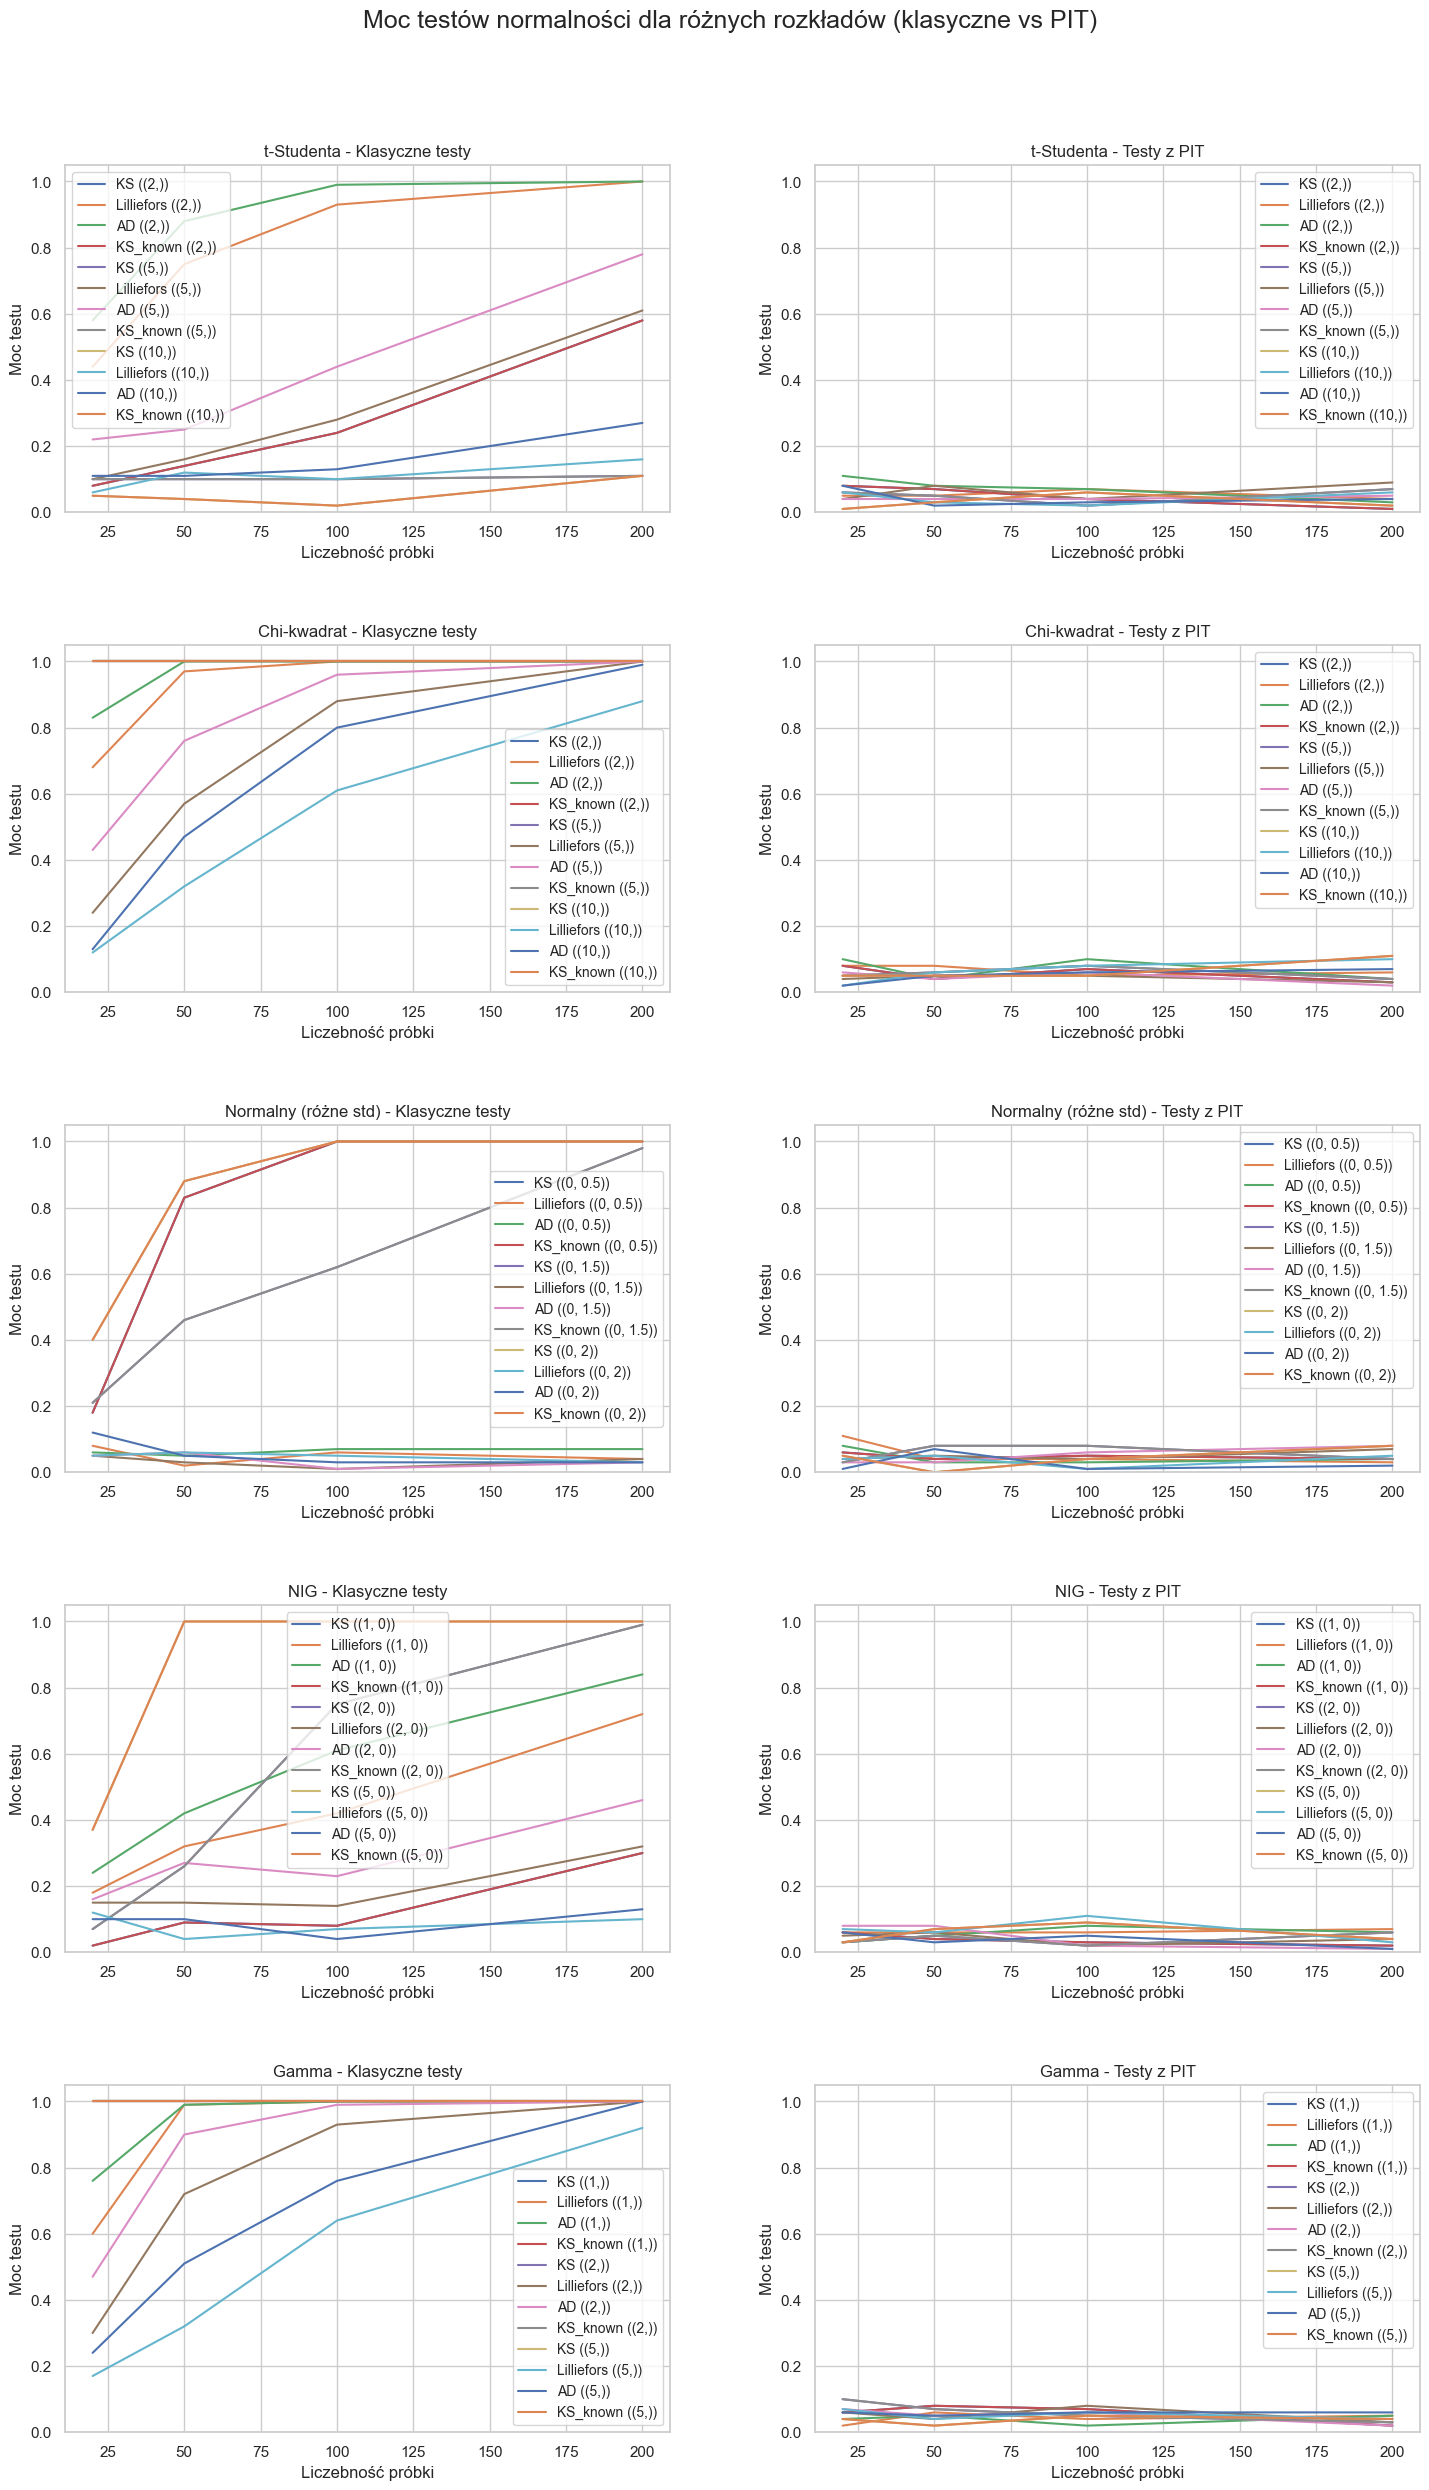

In [6]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import norminvgauss

sns.set(style="whitegrid")

# Parametry
np.random.seed(42)
sample_sizes = [20, 50, 100, 200]
n_simulations = 100
alpha = 0.05

# Testy normalności
def ks_test(data):
    return stats.kstest(data, 'norm')[1]

def lilliefors_test(data):
    _, p = lilliefors(data)
    return p

def anderson_darling_test(data):
    result = stats.anderson(data, dist='norm')
    return result.statistic > result.critical_values[2]

def ks_known_params_test(data):
    standardized = (data - 0) / 1  # zakładamy N(0,1)
    return stats.kstest(standardized, 'norm')[1]

# PIT
def pit_transform(data, cdf_func):
    uniform_vals = cdf_func(data)
    return stats.norm.ppf(uniform_vals)

# Obliczanie mocy testów
def compute_power(dist, params, cdf_func, use_pit=False):
    results = { 'KS': [], 'Lilliefors': [], 'AD': [], 'KS_known': [] }

    for size in sample_sizes:
        rejections = { 'KS': 0, 'Lilliefors': 0, 'AD': 0, 'KS_known': 0 }

        for _ in range(n_simulations):
            data = dist.rvs(*params, size=size)

            if use_pit:
                try:
                    data = pit_transform(data, cdf_func)
                except:
                    continue

            if ks_test(data) < alpha:
                rejections['KS'] += 1
            if lilliefors_test(data) < alpha:
                rejections['Lilliefors'] += 1
            if anderson_darling_test(data):
                rejections['AD'] += 1
            if ks_known_params_test(data) < alpha:
                rejections['KS_known'] += 1

        for key in results:
            results[key].append(rejections[key] / n_simulations)

    return results

# Lista rozkładów do analizy
distributions = [
    {
        'name': 't-Studenta',
        'dist': stats.t,
        'param_list': [(2,), (5,), (10,)],
        'cdf': lambda df: lambda x: stats.t.cdf(x, df)
    },
    {
        'name': 'Chi-kwadrat',
        'dist': stats.chi2,
        'param_list': [(2,), (5,), (10,)],
        'cdf': lambda df: lambda x: stats.chi2.cdf(x, df)
    },
    {
        'name': 'Normalny (różne std)',
        'dist': stats.norm,
        'param_list': [(0, 0.5), (0, 1.5), (0, 2)],
        'cdf': lambda mu, sigma: lambda x: stats.norm.cdf(x, loc=mu, scale=sigma)
    },
    {
        'name': 'NIG',
        'dist': norminvgauss,
        'param_list': [(1, 0), (2, 0), (5, 0)],
        'cdf': lambda a, b: lambda x: norminvgauss.cdf(x, a, b)
    },
    {
        'name': 'Gamma',
        'dist': stats.gamma,
        'param_list': [(1,), (2,), (5,)],
        'cdf': lambda a: lambda x: stats.gamma.cdf(x, a)
    }
]

# Rysowanie wykresów
fig, axes = plt.subplots(len(distributions), 2, figsize=(16, 5 * len(distributions)))
fig.tight_layout(pad=6)

for i, dist_info in enumerate(distributions):
    for params in dist_info['param_list']:
        cdf_func = dist_info['cdf'](*params)
        power_classic = compute_power(dist_info['dist'], params, cdf_func, use_pit=False)
        power_pit = compute_power(dist_info['dist'], params, cdf_func, use_pit=True)

        for test_name in power_classic:
            label = f"{test_name} ({params})"
            axes[i][0].plot(sample_sizes, power_classic[test_name], label=label)
            axes[i][1].plot(sample_sizes, power_pit[test_name], label=label)

    axes[i][0].set_title(f"{dist_info['name']} - Klasyczne testy")
    axes[i][1].set_title(f"{dist_info['name']} - Testy z PIT")
    for j in range(2):
        axes[i][j].set_xlabel("Liczebność próbki")
        axes[i][j].set_ylabel("Moc testu")
        axes[i][j].set_ylim(0, 1.05)
        axes[i][j].legend(fontsize='small')

plt.suptitle("Moc testów normalności dla różnych rozkładów (klasyczne vs PIT)", fontsize=18, y=1.02)
plt.show()


# Zadanie 2
Wpływ liczebności danych na moc testów
Analiza mocy testów w zależności od wielkości próbki. Przeanalizować różne liczebności próbki, aby określić, jak zmienia się moc testu w miarę wzrostu liczby obserwacji.

# Zadanie 3
Analiza błędu I rodzaju
Przeprowadzenie symulacji w celu oszacowania odsetka odrzuceń prawdziwej hipotezy zerowej (błąd I rodzaju) w przypadku weryfikacji zgodności z rozkładem NIG oraz gamma. Porównanie wyników klasycznej metody testowania z metodą wykorzystującą PIT.

# Zadanie 4
Wizualizacja wyników
Wyniki analizy przedstawić w formie wykresów ilustrujących moc testów w zależności od:

- Liczebności próbki,
- Parametrów generowanych rozkładów (stopni swobody, odchylenia standardowego, parametry rozkładów NIG i gamma). Każdy wykres zostanie odpowiednio opisany i oznaczony, aby możliwa była łatwa interpretacja wyników.